# Overview

This is a simple example of a `MultiTaskGP` with a very small dataset generated by hand. 

The input `X` created below is two-dimensional (i.e. two features for each training example), but the second feature corresponds to the fidelity (its value is 0 for low-fidelity points and 1 for high-fidelity points). We indicate that this feature is the fidelity one by passing `task_feature=-1` to `MultiTaskGP`.

In [1]:
import matplotlib.pyplot as plt

import torch
from botorch.models import MultiTaskGP
from botorch.fit import fit_gpytorch_mll
from gpytorch.mlls import ExactMarginalLogLikelihood

/opt/miniconda3/envs/lume-latest-botorch/lib/python3.12/site-packages/linear_operator/utils/interpolation.py:71: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at /private/var/folders/c_/qfmhj66j0tn016nkx_th4hxm0000gp/T/abs_35qhz7nt_q/croot/libtorch_1738269285820/work/torch/csrc/utils/tensor_new.cpp:653.)
  summing_matrix = cls(summing_matrix_indices, summing_matrix_values, size)


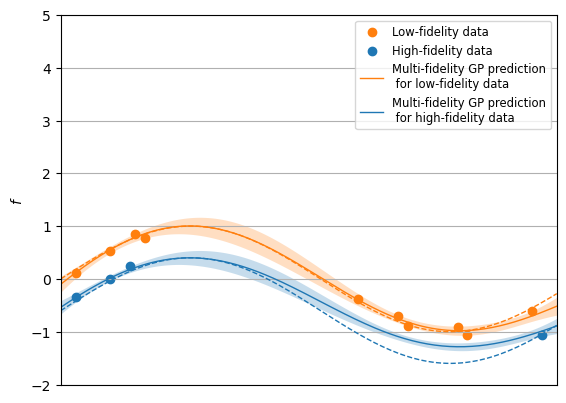

In [2]:
X1 = torch.tensor([0.03, 0.1, 0.15, 0.17, 0.6, 0.68, 0.7, 0.8, 0.82, 0.95]).to(
    dtype=torch.float64
)
X1 = torch.stack([X1, torch.zeros_like(X1)], dim=-1)
X2 = torch.tensor([0.03, 0.1, 0.14, 0.97]).to(dtype=torch.float64)
X2 = torch.stack([X2, torch.ones_like(X2)], dim=-1)

X = torch.cat([X1, X2])
y = 0.2 * (torch.rand(len(X), 1) - 0.5) + torch.sin(6 * X[:, 0:1]) - 0.6 * X[:, 1:]

gp = MultiTaskGP(X, y, task_feature=-1)
mll = ExactMarginalLogLikelihood(gp.likelihood, gp)
fit_gpytorch_mll(mll)

x = torch.linspace(0, 1, 200).reshape(-1, 1)
with torch.no_grad():
    p = gp.posterior(x)

    # get the mean
    m = p.mean

    # get the 2 sigma confidence region around the mean
    l, u = p.mvn.confidence_region()  # noqa: E741

plt.ylabel("$f$")

plt.fill_between(x.squeeze(), l[:, 1], u[:, 1], alpha=0.25, lw=0, color="C0")
plt.fill_between(x.squeeze(), l[:, 0], u[:, 0], alpha=0.25, lw=0, color="C1")

plt.scatter(
    X[:, 0][X[:, 1] == 0], y[X[:, 1] == 0], color="C1", label="Low-fidelity data"
)
plt.scatter(
    X[:, 0][X[:, 1] == 1], y[X[:, 1] == 1], color="C0", label="High-fidelity data"
)
plt.plot(
    x,
    m[:, 0],
    color="C1",
    lw=1,
    label="Multi-fidelity GP prediction\n for low-fidelity data",
)

plt.plot(
    x,
    m[:, 1],
    color="C0",
    lw=1,
    label="Multi-fidelity GP prediction\n for high-fidelity data",
)
plt.plot(x, torch.sin(6 * x), color="C1", lw=1, ls="--")
plt.plot(x, torch.sin(6 * x) - 0.6, color="C0", lw=1, ls="--")

plt.legend(loc=0, fontsize="small")
plt.xlim(0, 1)
plt.xticks([])
plt.ylim(-2, 5)
plt.grid()

The plot above shows the model prediction for the low-fidelity (orange) and high-fidelity (blue). In particular, the prediction uncertainty for the high-fidelity is relatively low near the presence of low-fidelity points (despite a systematic vertical? shift between the low-fidelity and high-fidelity points, in this example)

# Run with LUME-Model

In [3]:
from lume_model.variables import ScalarVariable, DistributionVariable
from lume_model.models.gp_model import GPModel

# Define inputs and outputs
input_variables = [ScalarVariable(name="x")]

output_variables = [
    DistributionVariable(name="output1", distribution_type="MultiVariateNormal"),
    DistributionVariable(name="output2", distribution_type="MultiVariateNormal"),
]


gp.eval()
# Create lume_model instance
gp_lume_model = GPModel(
    model=gp, input_variables=input_variables, output_variables=output_variables
)

In [4]:
input_dict = {"x": x.to(dtype=torch.double)}

In [5]:
# Evaluate function returns a dictionary mapping each output to a torch.distributions.Distribution
output_dict = gp_lume_model.evaluate(input_dict)

/Users/smiskov/Documents/SLAC/AD/ad-lume/lume-model/lume_model/models/gp_model.py:298: UserWarning: Covariance matrix is not positive definite. Attempting to fix. This may lead to inaccurate predictions.
  warnings.warn(


### Print plot with LUME-model results

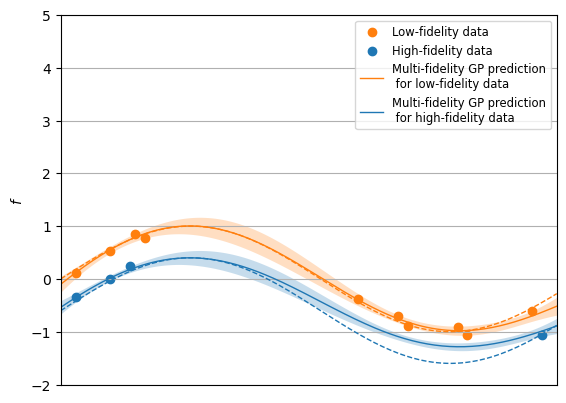

In [6]:
l1, u1 = (
    output_dict["output1"].mean.sub(output_dict["output1"].variance.sqrt().mul_(2)),
    output_dict["output1"].mean.add(output_dict["output1"].variance.sqrt().mul_(2)),
)
l2, u2 = (
    output_dict["output2"].mean.sub(output_dict["output2"].variance.sqrt().mul_(2)),
    output_dict["output2"].mean.add(output_dict["output2"].variance.sqrt().mul_(2)),
)

plt.ylabel("$f$")

plt.fill_between(
    x.squeeze(), l2.detach().numpy(), u2.detach().numpy(), alpha=0.25, lw=0, color="C0"
)
plt.fill_between(
    x.squeeze(), l1.detach().numpy(), u1.detach().numpy(), alpha=0.25, lw=0, color="C1"
)

plt.scatter(
    X[:, 0][X[:, 1] == 0], y[X[:, 1] == 0], color="C1", label="Low-fidelity data"
)
plt.scatter(
    X[:, 0][X[:, 1] == 1], y[X[:, 1] == 1], color="C0", label="High-fidelity data"
)
plt.plot(
    x,
    m[:, 0],
    color="C1",
    lw=1,
    label="Multi-fidelity GP prediction\n for low-fidelity data",
)

plt.plot(
    x,
    m[:, 1],
    color="C0",
    lw=1,
    label="Multi-fidelity GP prediction\n for high-fidelity data",
)
plt.plot(x, torch.sin(6 * x), color="C1", lw=1, ls="--")
plt.plot(x, torch.sin(6 * x) - 0.6, color="C0", lw=1, ls="--")

plt.legend(loc=0, fontsize="small")
plt.xlim(0, 1)
plt.xticks([])
plt.ylim(-2, 5)
plt.grid()